In [262]:
## Our default imports: who can live without these :)
%matplotlib inline

import warnings
warnings.filterwarnings('default', category=DeprecationWarning, module='.*/mypackage/.*')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

# Welcome to JSPlot!

### Real Time Widgets in HTML Exports


The goal of this project is to create a set of tools to allow for interactive input/output without an iPython backend. To see what we mean, check out [A Live Version](https://dibya.xyz/JupyterJSPlot.html)


This project stems from the fact, that when distributing teaching materials, students are often limited in their resources; not only may they not have access to computers, oftentimes, they don't have the technical expertise to get everything set up. Thus, the web!

Ipython has a set of very nifty tools called widgets (ipywidgets), which allow for interactive input, allowing one to see the effects of tweaking parameters in various functions.  We want to bring the same functionality to HTML pages, without sacrificing ease of use on the developer end.

### How it Works


We use cell magics, a tool in iPython, to bring widgetry to HTML. Consider a cell like this

    ###################
    %%jsPlot chartType [parameterName,start,end,step] ...

    def data(yourParameters):
        called every time parameters change
    ###################
    
chartType can be any of the following:
- l : line
- b : bar
- lb: line+bar


Here's an example 
    ########################
    %%jsPlot l ['x',0,10,1]
    def data(x):
        r = list(range(x))
        y = [math.pow(i,2) for i in r]
        plot(r,y)
        console.log(y)
        bar(r,r)
    #########################

In [245]:
ht = """
	<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/3.1.0/jquery.min.js"></script>
	<script>JSSOURCE</script>
	<script src="https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.17/d3.js"></script>
	<script src="https://cdn.rawgit.com/novus/nvd3/master/build/nv.d3.min.js"></script>
	<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/nvd3/1.8.4/nv.d3.min.css">
	<link href='http://fonts.googleapis.com/css?family=Quantico' rel='stylesheet' type='text/css'>
	<script src="https://cdnjs.cloudflare.com/ajax/libs/jstat/1.5.3/jstat.min.js"></script>
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
  <script src="numjs.min.js"></script>

	<div class="container-fluid">
	<div id="chartPID" class="col-md-9">
	<svg  style="height:500px"></svg>
	</div>
	<div id="slidersPID" class="col-md-3">
  	</div>
	</div>
	<script>\

    var historicalBarChartPID = [
        
    { 
      "key" : "" , 
      "bar": true,
      "color": "#ccf",
      "values" : []}
    ];
    var chartPID;
    function sliderToHTML(name,min,max,step){
      var htmlZ = '<div class="slider"><label>'+name+'</label><input type = "range" min="'+min+'" max="'+max+'" step="'+step+'" onchange="'+name+'valuePID.value=value;updatePID();"/><output class="slider" id="'+name+'valuePID">'+(min+max)/2+'</output></div>';
      return htmlZ;
    }
    
    function addSlider(name,min,max,step){
      var html = sliderToHTML(name,min,max,step);
      var sLoc = $('#slidersPID');
      sLoc.html(sLoc.html()+html);
    }

    function addAllSliders(){
      sls = tmpPID.inputs();
      for(i = 0; i < sls.length; i++){
        inp = sls[i];
        addSlider(inp[0],inp[1],inp[2],inp[3]);
      }
    }
    var colors = ['#aec7e8', '#7b94b5', '#486192','#aec7e8', '#7b94b5', '#486192','#aec7e8', '#7b94b5', '#486192'];
    function addplotPID(a,b,bar){
        var c = a.map(function (e, i) {
        return [a[i], b[i]];
        });
        historicalBarChartPID.push( { 
      "key" : ""+historicalBarChartPID.length , 
      "color": colors[historicalBarChartPID.length],
      "values" : c,
      "bar":bar});
      chartn = d3.select('#chartPID svg');
    chartn.datum(historicalBarChartPID).transition().duration(500).call(chartPID);
    nv.utils.windowResize(chartPID.update); 
    }
    
    
    
    function plotPID(a,b){
        addplotPID(a,b,false);
    }
    
    function barPID(a,b){
        addplotPID(a,b,true);
    }
    
    function setTypePID(type){
        clearPID();
        if(type=='l'){
            nv.addGraph(function() {
            chartPID = nv.models.lineChart()
                .x(function(d) { return d[0] })
                .y(function(d) { return d[1] })
                //.staggerLabels(historicalBarChart[0].values.length > 8)
                .duration(250)
                ;
            d3.select('#chartPID svg')
                .datum(historicalBarChartPID)
                .call(chartPID);
            nv.utils.windowResize(chartPID.update);
            updatePID();
            return chartPID;
        });
        } else if (type == 'b'){
            nv.addGraph(function() {
            chartPID = nv.models.discreteBarChart()
                .x(function(d) { return d[0] })
                .y(function(d) { return d[1] })
                //.staggerLabels(historicalBarChart[0].values.length > 8)
                .duration(250)
                ;
            d3.select('#chartPID svg')
                .datum(historicalBarChartPID)
                .call(chartPID);
            nv.utils.windowResize(chartPID.update);
            updatePID();
            return chartPID;
        });
        }
        else {
        nv.addGraph(function() {
        chartPID = nv.models.linePlusBarChart()
            .x(function(d) { return d[0] })
            .y(function(d) { return d[1] })
            .duration(250)
            ;
        d3.select('#chartPID svg')
            .datum(historicalBarChartPID)
            .call(chartPID);
        nv.utils.windowResize(chartPID.update);
        updatePID();
        return chartPID;
    });
        }
    
    }
    addAllSliders();
    function updatePID() {
        historicalBarChartPID = [];
    	var values = $.map($("#slidersPID output"), function(x){return parseFloat(x.value);});
    	tmpPID.data.apply(this,values);
	};
    
    function clearPID() {
        d3.selectAll("#chartPID svg > *").remove();
    }
    setTypePID(tmpPID.setup());
</script>

"""

In [258]:
from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)
from IPython.core.display import display, HTML
from subprocess import call
import time
import os

pythonFile = """
math = Math

def setup():
    return '%s'
def inputs():
    return [%s]

%s
"""
pid = 0

@register_cell_magic
def jsPlot(line, cell):
    global pid
    pid += 1
    mode,parameter = line[:line.find(" ")], line[line.find(" "):]
    print(mode)
    print(parameter)
    pF = pythonFile%(mode,parameter,cell)
    pF = pF.replace("plot","plot"+str(pid))
    pF = pF.replace("bar","bar"+str(pid))

    fileName = 'tmp%d'%pid
    f = open(fileName+'.py','w')
    f.write(pF)
    f.close()
    call(["transcrypt", fileName+".py",'--nomin'])
    js = open("__javascript__/"+fileName+".js").read()
    js = js.replace('enumerable: true', 'enumerable: true, configurable:true')
    os.remove(fileName+'.py')
    os.remove("__javascript__/"+fileName+".js")
    print(pid)
    return HTML(ht.replace("JSSOURCE",js).replace("PID",str(pid)))



In [259]:
%%jsPlot l ['x',0,10,1]
def data(x):
    r = list(range(x))
    y = [math.pow(i,2) for i in r]
    plot(r,y)
    console.log(y)
    bar(r,r)

l
 ['x',0,10,1]
1


In [260]:
%%jsPlot lb ['n',0,100,5], ['p',0,1,.1]
#BINOMIAL PROBABILITIES

def prob(n,p,x):
	q = 1-p
	nx = n - x
	return jStat.combination(n,x)*Math.pow(p,x)*Math.pow(q,nx)

def data(n,p):
    x = list(range(n+1))
    y =  [prob(n,p,i) for i in x]
    y2 = [jStat.normal.pdf(i,n*p,math.sqrt(n*p*(1-p))) for i in x]
    bar(x,y)
    plot(x,y2)


lb
 ['n',0,100,5], ['p',0,1,.1]
2


In [261]:
%%jsPlot b ['mu',0,10,1]
#POISSON PROBABILITIES

def factorial(x):
    i = 1
    for _ in range(1,x+1):
        i *= _
    return i

def prob(mu,x):
	return math.pow(math.E,-1*mu)*math.pow(mu,x)/factorial(x)

def data(mu):
    x = list(range(4*mu))
    y = [prob(mu,i) for i in x]
    plot(x,y)


b
 ['mu',0,10,1]
3


In [130]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed


In [100]:
def plots(expr,val,discrete=False):
    variable,start,end = val
    if discrete:
        x = np.linspace(start,end,end-start+1)
    else:
        x = np.linspace(start,end,100)
    y = [expr.subs(variable,i).evalf() for i in x]
    if not discrete:
        plt.plot(x,y)
    else:
        plt.bar(x-.5,y)
    plt.ylim(ymin=0)

In [101]:
import mpmath
class BinomialDistribution:
    def __init__(self,n,p):
        self.x = symbols("x")
        self.formula = binomial(n,x)*p**x*(1-p)**(n-x)
        self.n = n
        self.p = p
    def plot(self):
        plots(self.formula,(self.x,0,self.n),True)

    def vary(startn=10,startp=.5):
        import time
        a = time.time()
        def plott(n,p):
            nonlocal a
            if time.time()-a < .1:
                return
            BinomialDistribution(n,p).plot()
            a = time.time()
        interact(plott,n=widgets.IntSlider(min=1,max=200,value=startn),p=widgets.FloatSlider(value=startp,min=0,max=1,step=.01))


In [103]:
%matplotlib inline
BinomialDistribution.vary()

# Estimating Pi

In this example, we use monte-carlo simulation to estimate the value of $\pi$. The goal of this experiment is to introduce more creative methods of sampling to obtain our estimations.

Consider the unit circle, particularly the region in the 1st quadrant. As you know, the area of that region of the circle is $\frac{1}{4}\pi r^2$, or in our case , $\frac{\pi}{4}$. 

Now, let's pretend that we're dropping dots on the unit square [0,1]x[0,1]. What percentage of those dots do we expect to land inside the circle? 
$$p = \cfrac{\frac{\pi}{4}}{1} = \frac{\pi}{4}$$.

Let's say that we've dropped some dots on the unit square, and the approximate portion that landed in the circle was $\hat{p}$. What's our estimate for $\pi$?

$$\hat{\pi} = 4 * \hat{p}$$

<IPython.core.display.Javascript object>


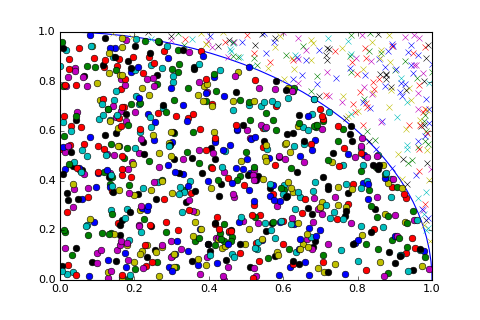

78498 out of 100000 dots landed in the circle: p = 0.784980
Pi estimate is  3.13992


In [185]:
%matplotlib notebook
circle1=plt.Circle((0,0),1,color='w',ec='b')
plt.gcf().gca().add_artist(circle1)
import random
import time
plt.xlim(0,1)
plt.ylim(0,1)
v = 0
n = 100000
for _ in range(n):
    x = random.random()
    y = random.random()
    if x**2 + y**2 > 1:
        if _%(n//1000) == True:
            plt.plot([x],[y],marker='x')
    else:
        if _%(n//1000) == True:
            plt.plot([x],[y],marker='o')
        v += 1

print("%d out of %d dots landed in the circle: p = %f"%(v,n,v/n))
print("Pi estimate is ", (v*4/n))